# #Fields from Snyder

In [1]:
%load_ext autoreload
%autoreload 2
import wavesight as ws
from matplotlib import pyplot as plt
import cmasher as cmr
import numpy as np
from matplotlib.patches import Circle

In [2]:
fiber_spec = {'nCladding': 1.5,
    'nCore': 2.5,
    'coreRadius': 1.0,
    'λFree': 0.532,
    'nFree': 1.0,
    'grid_divider': 2
    }
fiber_sol = ws.multisolver(fiber_spec, verbose=True,solve_modes='all')

Approx number of complex HE modes:  127
Approx number of TE modes:  11
Approx number of TM modes:  11
Approx number of total modes:  278
Approx Max n for HE modes:  15
Calculating TM(0,n) propagation constants ...
Calculating TE(0,n) propagation constants ...
Calculating HE(m,n) propagation constants ...
m=20
HE modes = 266
TE modes = 7
TM modes = 7
TOTAL modes = 280
FROM_Vnum = 278


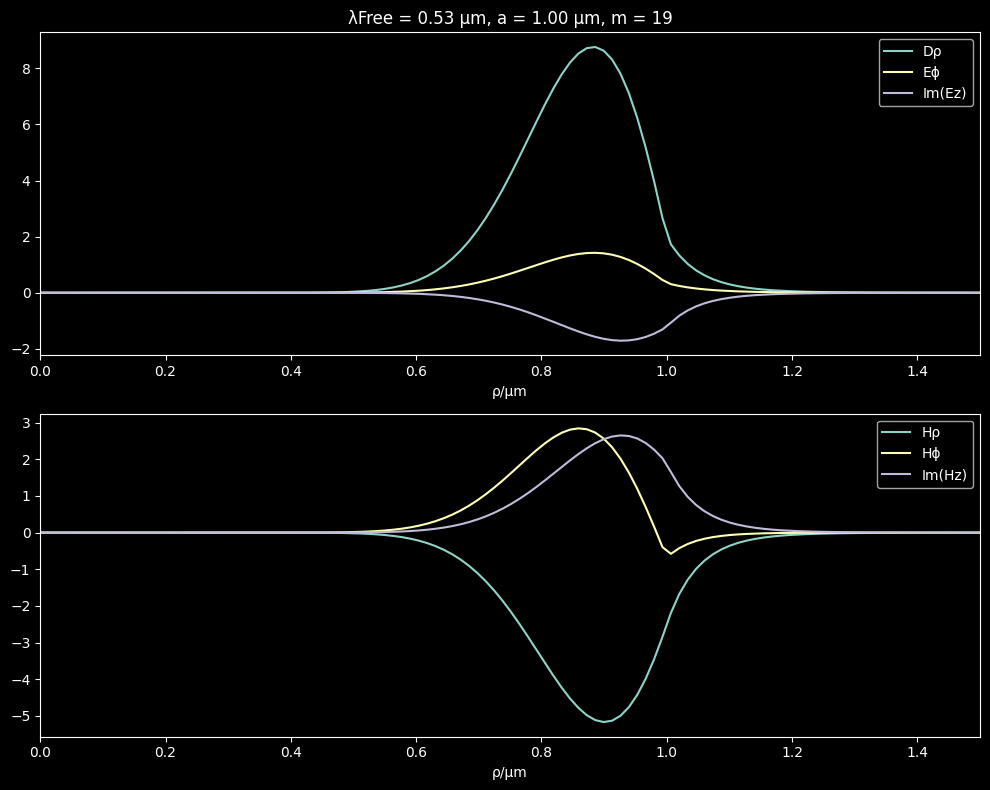

In [8]:
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
λFree = 2*np.pi/kFree
fieldType = 'HE'
m = max(fiber_sol['HEkz'].keys())
kz = fiber_sol[fieldType + 'kz'][m][-1]
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']
Efuncs, Hfuncs = ws.fieldGenerator(a=a, kFree=kFree, kz=kz, m=m, nCladding=nCladding, nCore=nCore, fieldType=fieldType)
(ECoreρ, ECoreϕ, ECorez, ECladdingρ, ECladdingϕ, ECladdingz) = Efuncs
(HCoreρ, HCoreϕ, HCorez, HCladdingρ, HCladdingϕ, HCladdingz) = Hfuncs
def Efun(a):
    def fun(ρ):
        if ρ<a:
            return ECoreρ(ρ), ECoreϕ(ρ), ECorez(ρ)
        else:
            return ECladdingρ(ρ), ECladdingϕ(ρ), ECladdingz(ρ)
    return fun
def Hfun(a):
    def fun(ρ):
        if ρ<a:
            return HCoreρ(ρ), HCoreϕ(ρ), HCorez(ρ)
        else:
            return HCladdingρ(ρ), HCladdingϕ(ρ), HCladdingz(ρ)
    return fun

N = 150
dρ = a/N
ptitle = f'λFree = {λFree:.2f} μm, a = {a:.2f} μm, m = {m}'
ρrange = np.linspace(0,2*a,N)
electricFun = Efun(a)
electricFun = np.vectorize(electricFun)
magneticFun = Hfun(a)
magneticFun = np.vectorize(magneticFun)
Evals = electricFun(ρrange)
Hvals = magneticFun(ρrange)
refIndex = np.zeros(N)
refIndex[ρrange<a] = nCore
refIndex[ρrange>=a] = nCladding
permittivity = refIndex**2
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(ρrange,Evals[0]*permittivity,label='Dρ')
axes[0].plot(ρrange,Evals[1],label='Eϕ')
axes[0].plot(ρrange,np.imag(Evals[2]),label='Im(Ez)')
axes[1].plot(ρrange,Hvals[0],label='Hρ')
axes[1].plot(ρrange,Hvals[1],label='Hϕ')
axes[1].plot(ρrange,np.imag(Hvals[2]),label='Im(Hz)')
for ax in axes:
    ax.set_xlim(0,1.5*a)
    ax.set_xlabel('ρ/μm')
    ax.legend()
axes[0].set_title(ptitle)
plt.tight_layout()
plt.show()

In [11]:
# test all modes for boundary conditions
a = fiber_spec['coreRadius']
kFree = fiber_spec['kFree']
nCladding = fiber_spec['nCladding']
nCore = fiber_spec['nCore']
λFree = 2*np.pi/kFree
allTests = []
for fieldType in ['TM', 'TE', 'HE']:
    allkzs = fiber_sol[fieldType + 'kz']
    for m, kzs in allkzs.items():
        for kzidx, kz in enumerate(kzs):
            Efuncs, Hfuncs = ws.fieldGenerator(a=a, kFree=kFree, kz=kz, m=m, nCladding=nCladding, nCore=nCore, fieldType=fieldType)
            test = ws.boundary_test(Efuncs, Hfuncs, fiber_spec, modeType=fieldType)
            allTests.append((fieldType, m, kzidx, kz, test))
# find all failed tests
failed = list(filter(lambda x: not x[-1][0], allTests))
print("%d/%d failed" % (len(failed), len(allTests)))

0/147 failed


In [14]:
# calculate the numerical basis for the Snyder model
fiber_sol = ws.calculate_numerical_basis(fiber_sol, verbose=False)

/Users/juan/ZiaLab/Codebase/wavesight/fieldgenesis.py:713: RuntimeWarning: invalid value encountered in scalar add
  return -0.5*(a*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.kn(-1 + m,(np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*ρ)/a)*(-1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))))/(a*(kz**2 - kFree**2*nCladding**2)*np.sqrt(-kz**2 + kFree**2*nCore**2)*(special.jv(-1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)) - special.jv(1 + m,a*np.sqrt(-kz**2 + kFree**2*nCore**2)))*special.kn(m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))*(kz**2 - kFree**2*nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nCore**2))*(special.kn(-1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2))) + special.kn(1 + m,np.sqrt(a**2*(kz**2 - kFree**2*nCladding**2)))))) + (1 - (2*kFree**2*m*(nCladding**2 - nCore**2)*special.jv(m,a*np.sqrt(-kz**2 + kFree**2*nC

In [15]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']
eigenbase = np.copy(fiber_sol['eigenbasis'])
wavenums = fiber_sol['eigenbasis_nums']

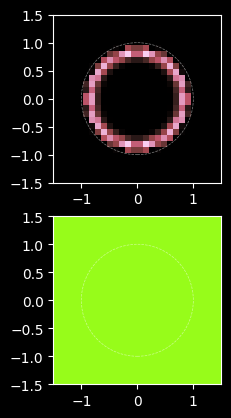

In [16]:
modeIndex = -10
E_field = eigenbase[modeIndex][0]
H_field = eigenbase[modeIndex][1]
eigennums = wavenums[0]
plotField = 0.5*(E_field[0] * np.conjugate(H_field[1]) - E_field[1] * np.conjugate(H_field[0]))
plotField0 = np.real(plotField)
plotField1 = np.imag(plotField)
extent = [-b, b, -b, b]
ranger = np.max(np.abs(plotField0))
fig, axes = plt.subplots(nrows=2)
imshow = axes[0].imshow(plotField0, vmin=-ranger, vmax=ranger,cmap=cmr.watermelon, extent=extent)
circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
axes[0].add_patch(circle)
imshow = axes[1].imshow(plotField1, cmap=cmr.watermelon, extent=extent)
circle = Circle((0,0), a, linestyle='--', edgecolor='white', facecolor='none', alpha=0.5, linewidth=0.5)
axes[1].add_patch(circle)
plt.show()

In [17]:
a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

In [19]:
# check to see if the resulting basis is orthonormal
dotProducts = []
dodDir = {}
for i in range(len(eigenbase)):
    for j in range(len(eigenbase)):
        if (j, i) in dodDir:
            dotProducts.append(dodDir[(j, i)])
            continue
        E_field = eigenbase[i][0]
        H_field = eigenbase[j][1]
        dotP = np.abs(ws.field_dot(E_field, H_field, Δs))
        dodDir[(i, j)] = dotP
        if i != j and dotP > 0.5:
            1/0
        dotProducts.append(dotP)
dotProducts = np.array(dotProducts)
dotProducts = dotProducts.reshape(len(eigenbase), len(eigenbase))

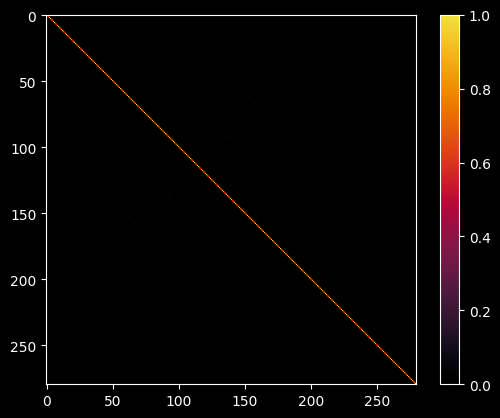

In [20]:
plt.figure()
plt.imshow(dotProducts, vmin=0, vmax=1, cmap=cmr.ember)
plt.colorbar()
plt.show()